## Import Statments and Dataset loading

In [1]:
import keras
import os
from keras import layers, Model
import tensorflow as tf
from Net3 import *
from PIL import Image
import numpy as np
from TextProcesser import TextProcesser
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['text.usetex'] = True


# disable GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# check for GPU access
physical_devices = tf.config.list_physical_devices('GPU')
print(f'GPU access: {physical_devices}')

# Define constants
BUFFER_SIZE = 1000
BATCH_SIZE = 16
MAX_TOKEN = 152
EPOCHS = 20

# replace with path to your processed data
DATA_DIR = '/home/stud/ge42nog/projects/processed_data/formula_images_processed/'
CHECKPOINT_PATH = '/home/stud/ge42nog/projects/im2latex_public/Net1/save5'

# load data
train = np.load('/home/stud/ge42nog/projects/im2latex_public/train_buckets.npy', allow_pickle=True)[0]
test = np.load('/home/stud/ge42nog/projects/im2latex_public/test_buckets.npy', allow_pickle=True)[0]
validate = np.load('/home/stud/ge42nog/projects/im2latex_public/validate_buckets.npy', allow_pickle=True)[0]


2024-02-03 19:20:36.519711: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-03 19:20:36.539205: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-03 19:20:36.539221: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-03 19:20:36.539986: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-03 19:20:36.543980: I tensorflow/core/platform/cpu_feature_guar

GPU access: []


2024-02-03 19:20:38.701111: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-02-03 19:20:38.701127: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: cip2ryzen4.cip.ph.tum.de
2024-02-03 19:20:38.701129: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: cip2ryzen4.cip.ph.tum.de
2024-02-03 19:20:38.701183: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.129.3
2024-02-03 19:20:38.701191: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.129.3
2024-02-03 19:20:38.701193: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.129.3


In [2]:

def load_im_from_filename(filename, size):
    '''
    input: path to file, size: relevant bucket size

    returns: normalized image file in float32 dtype
    
    '''
    raw = tf.io.read_file(filename)
    img = tf.io.decode_png(raw, 1) # type: ignore
    img = tf.cast(img, tf.float32)
    img = keras.layers.Rescaling(1./255)(img)
    img = tf.reshape(img, (size[1], size[0], 1))
    return img


def process_data(img, target):
    targ_in = target[:,:-1]
    targ_out = target[:,1:]
    return (img, targ_in), targ_out


def build_dataset(buckets, size):

    file_list = [(DATA_DIR + buckets[size][i][0]) for i in range(len(buckets[size]))]
    label_list = [np.array(buckets[size][i][1]) for i in range(len(buckets[size]))]
    for label in label_list:
        label.resize(MAX_TOKEN, refcheck=False) # padd labeles with zeroes to max length. inplace
        
    dataset_images = tf.data.Dataset.from_tensor_slices(file_list)
    dataset_images = dataset_images.map(lambda x: load_im_from_filename(x, size))
    dataset_labels = tf.data.Dataset.from_tensor_slices(label_list)

    dataset = tf.data.Dataset.zip(dataset_images, dataset_labels).batch(BATCH_SIZE, drop_remainder=True)

    dataset = dataset.map(process_data)

    return dataset


def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask
    # Return the total.
    final_loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return final_loss

def masked_acc(y_true, y_pred):
    # Calculate the accuracy for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)



# train dataset
train_ds_list = [build_dataset(train, size) for size in train.keys()]
# test dataset
test_ds_list = [build_dataset(test, size) for size in test.keys()]
# validation dataset
validate_ds_list = [build_dataset(validate, size) for size in validate.keys()]

# build complete datasets
complete_train_ds = train_ds_list[0]
for ds in train_ds_list[1:]:
    complete_train_ds = complete_train_ds.concatenate(ds)

complete_test_ds = test_ds_list[0]
for ds in test_ds_list[1:]:
    complete_test_ds = complete_test_ds.concatenate(ds)

complete_validate_ds = validate_ds_list[0]
for ds in validate_ds_list[1:]:
    complete_validate_ds = complete_validate_ds.concatenate(ds)


## Initialize Model und load weights

In [3]:
my_text_processor = TextProcesser()

model = Decompiler(my_text_processor, units=64, dec_units=128, name='decompiler')

model.compile(
    optimizer=keras.optimizers.Adam(clipnorm=1.),
    loss=masked_loss,
    metrics=[masked_loss, masked_acc],
)
model.load_weights('/home/stud/ge42nog/projects/pix2tex/mk3/net_saves/save2')




## Test Model with examples from the validation Dataset

In [4]:
rand1, rand2 = np.random.randint(0, 300), np.random.randint(0, 16) # choose random image and label

ds = complete_validate_ds.skip(rand1)
for (i,j),k in ds.take(1): # type: ignore
    input_image = tf.expand_dims(i[rand2], 0)

    # decompile
    p = model.decompile(input_image)
    label = model.Decoder.label_to_text(j[rand2])
    print(f'Prediction: \n {p}')
    print(f'Label: \n {label}')
    txte = rf"Prediction: ${p}$ \\ _."
    
    # plot image
    fig, ax = plt.subplots(figsize=(10,5))
    ax.imshow(input_image[0,:,:,:], cmap='gray')
    ax.set_title(txte, fontsize=14)

    plt.show()





1.0 0.0
Prediction: 
 \operatorname* { l i m } _ { \epsilon > 0 } \ \langle f , S _ { \mathrm { N S } } ^ { ( \epsilon ) } g \rangle = \langle f , S _ { \mathrm { N S } } g \rangle                                                    
Label: 
  \operatorname* { l i m } _ { \epsilon [UNK] 0 } \, \, \langle f , S _ { \mathrm { N S } } ^ { ( \epsilon ) } g \rangle = \langle f , S _ { \mathrm { N S } } g \rangle                                                                                                     


RuntimeError: latex was not able to process the following string:
b'Prediction: $\\\\operatorname* { l i m } _ { \\\\epsilon > 0 } \\\\ \\\\langle f , S _ { \\\\mathrm { N S } } ^ { ( \\\\epsilon ) } g \\\\rangle = \\\\langle f , S _ { \\\\mathrm { N S } } g \\\\rangle                                                    $ \\\\\\\\ _.'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpc7rm5h6l 753d6a395f63a9040a2dbe4bf5aef527.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./753d6a395f63a9040a2dbe4bf5aef527.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 753d6a395f63a9040a2dbe4bf5aef527.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Undefined control sequence.
<recently read> \operatorname 
                              
l.29 {\sffamily Prediction: $\operatorname
                                          * { l i m } _ { \epsilon > 0 } \ \...
No pages of output.
Transcript written on tmpc7rm5h6l/753d6a395f63a9040a2dbe4bf5aef527.log.




<Figure size 1000x500 with 1 Axes>

$$ a ( \eta ) = \sqrt { A + B \operatorname { t a n h } \frac { \eta } { \eta _ { 0 } } } \hspace { 1 cm } A > B , $$

problem with rendering the labels containing `\hspace{ c m }` cm must be written without whitespace

## Plotting the attention scores
Whats the shape affter the Cnn? 
> shape after Cnn is now safed as self.context_shape

1.0 0.0
(1, 100, 896)
[]


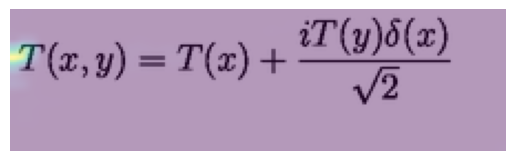

['T']


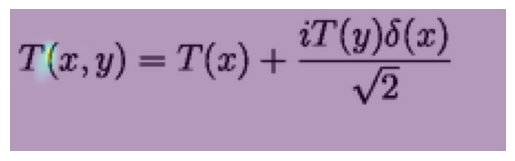

['T', '(']


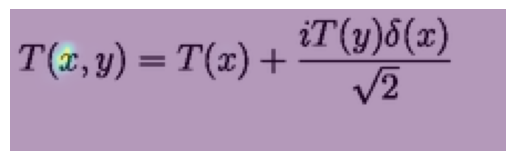

['T', '(', 'x']


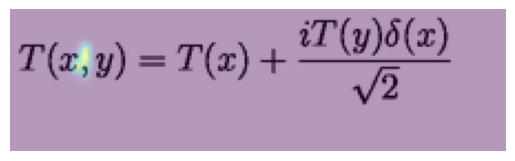

['T', '(', 'x', ',']


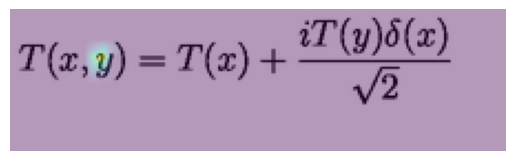

['T', '(', 'x', ',', 'y']


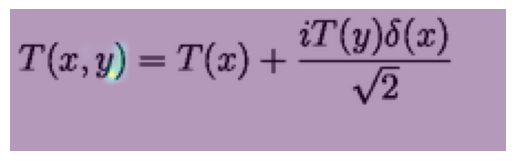

['T', '(', 'x', ',', 'y', ')']


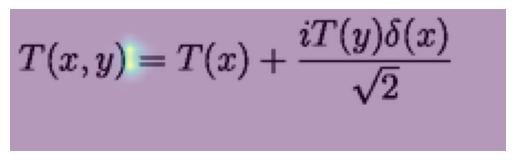

['T', '(', 'x', ',', 'y', ')', '=']


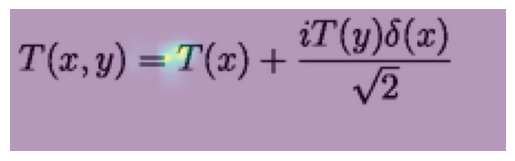

['T', '(', 'x', ',', 'y', ')', '=', 'T']


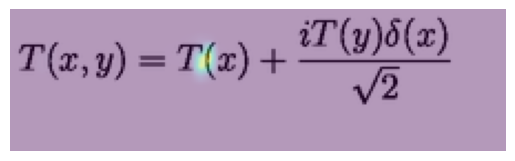

['(', 'x', ',', 'y', ')', '=', 'T', '(']


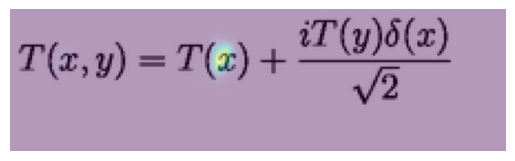

['x', ',', 'y', ')', '=', 'T', '(', 'x']


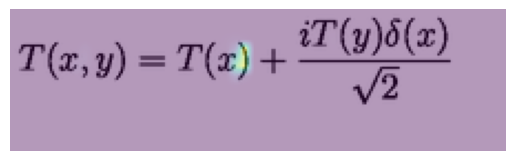

[',', 'y', ')', '=', 'T', '(', 'x', ')']


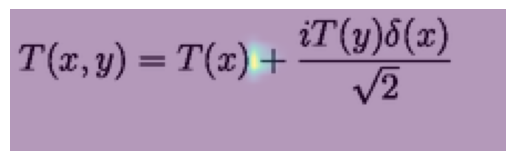

['y', ')', '=', 'T', '(', 'x', ')', '+']


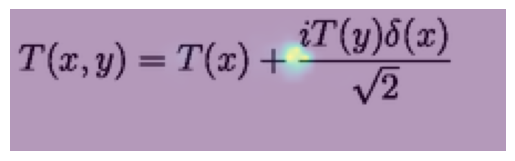

[')', '=', 'T', '(', 'x', ')', '+', '\\frac']


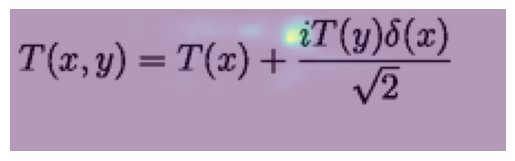

['=', 'T', '(', 'x', ')', '+', '\\frac', '{']


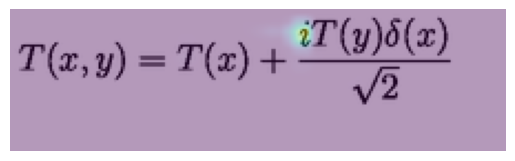

['T', '(', 'x', ')', '+', '\\frac', '{', 'i']


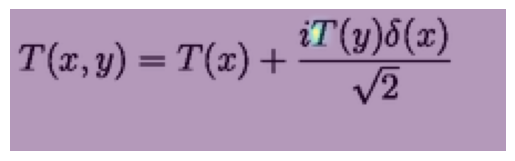

['(', 'x', ')', '+', '\\frac', '{', 'i', 'T']


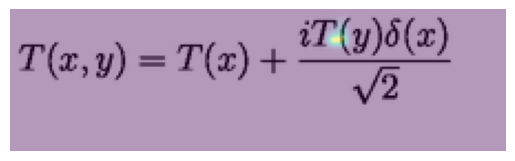

['x', ')', '+', '\\frac', '{', 'i', 'T', '(']


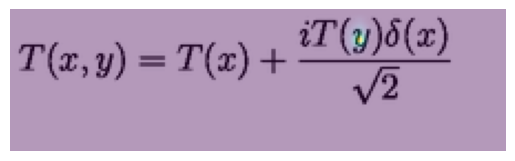

[')', '+', '\\frac', '{', 'i', 'T', '(', 'y']


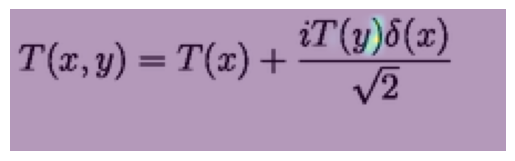

['+', '\\frac', '{', 'i', 'T', '(', 'y', ')']


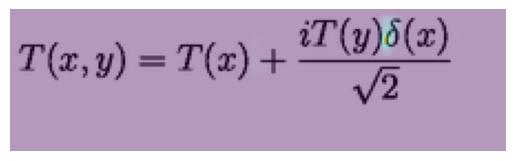

['\\frac', '{', 'i', 'T', '(', 'y', ')', '\\delta']


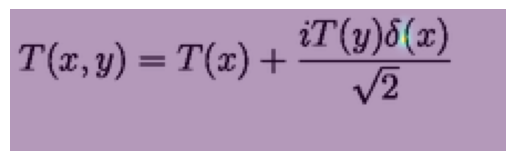

['{', 'i', 'T', '(', 'y', ')', '\\delta', '(']


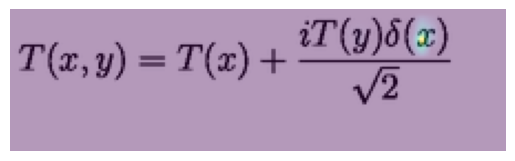

['i', 'T', '(', 'y', ')', '\\delta', '(', 'x']


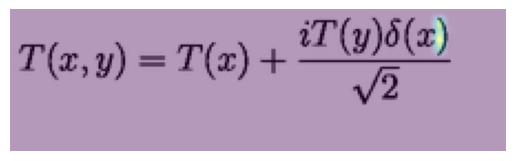

['T', '(', 'y', ')', '\\delta', '(', 'x', ')']


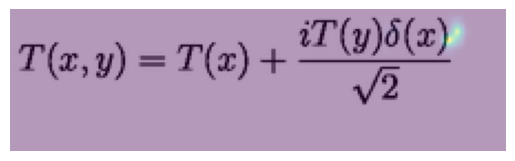

['(', 'y', ')', '\\delta', '(', 'x', ')', '}']


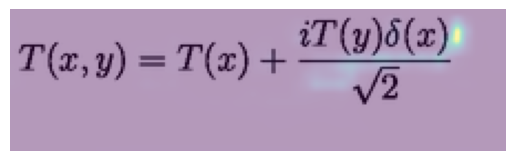

['y', ')', '\\delta', '(', 'x', ')', '}', '{']


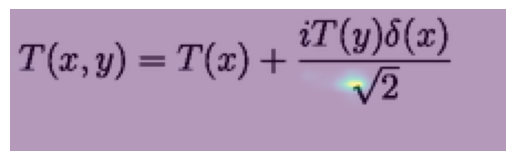

[')', '\\delta', '(', 'x', ')', '}', '{', '\\sqrt']


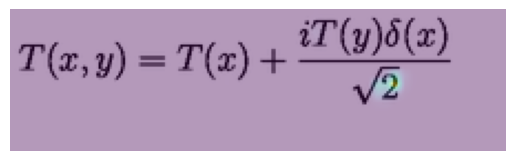

['\\delta', '(', 'x', ')', '}', '{', '\\sqrt', '{']


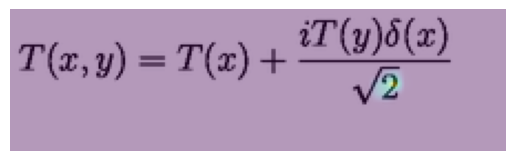

['(', 'x', ')', '}', '{', '\\sqrt', '{', '2']


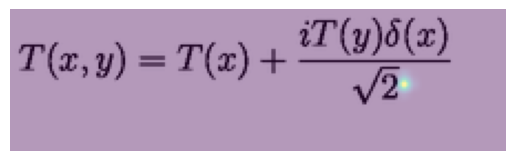

['x', ')', '}', '{', '\\sqrt', '{', '2', '}']


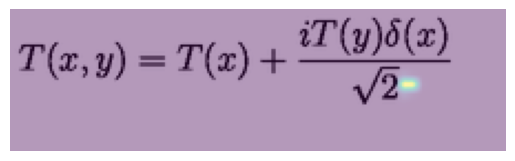

[')', '}', '{', '\\sqrt', '{', '2', '}', '}']


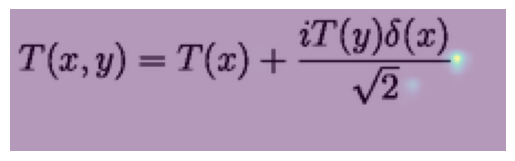

In [5]:
rand1, rand2 = np.random.randint(0, 300), np.random.randint(0, 16) # choose random image and label
ds = complete_validate_ds.skip(rand1)


for (i,j),k in ds.take(1): # type: ignore
    rcParams['text.usetex'] = False
    input_image = tf.expand_dims(i[rand2], 0)

    model.plot_attention(input_image)

## Try with custom image

### Things to keep in mind while preprocessing custom image
- padd with enough wihtespace at the end to help generate the `[END]` token
- Hight of one Line in formula should be around 40 - 45 to generate best results
- with the here used compiler the letters are sometimes falsely characterized as bold.

1.0 0.0


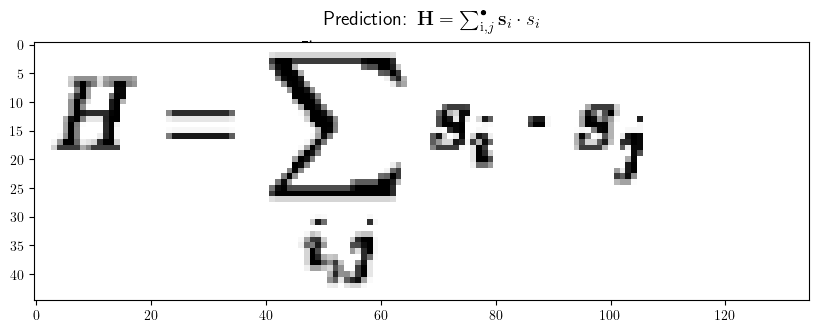

Prediction: 
 { \bf H } = \sum _ { \mathrm { i } , j } ^ { \bullet } { \bf s } _ { i } \cdot s _ { i }                                                                   


In [64]:
IMAGE_PATH = '/home/stud/ge42nog/projects/pix2tex/data/CodeCogsEqn.png'

def predict_image(path=IMAGE_PATH):
    # prepare image

    # TODO: automate preprocessing of image to fit model input

    my_image = plt.imread(path)
    img = np.pad(my_image[:,:,0], ((3,3), (3,30)), constant_values=1)
    input_image = tf.expand_dims(tf.expand_dims(img, axis=0), axis=-1)
    input_image = tf.image.resize(input_image, (45,1300), preserve_aspect_ratio=True)
    # decompile
    p = model.decompile(input_image)
    

    # plot image
    txte = rf"Prediction: ${p}$ \\ _."
    fig, ax = plt.subplots(figsize=(10,5))
    ax.imshow(input_image[0,:,:,:], cmap='gray') # type: ignore
    try:
        ax.set_title(txte, fontsize=14)
        plt.show()
    except:
        ax.set_title(f'Not able to compile predicted formula...')
        plt.show()


    print(f'Prediction: \n {p}')
    

predict_image()